In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
df = pd.read_csv('data/product_demand.csv')
df = df.dropna()
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [3]:
df['Product_Code'].value_counts()[:3]

Product_1359    16936
Product_1295    10575
Product_1378     9770
Name: Product_Code, dtype: int64

In [4]:
df = df.loc[df['Product_Code'] == 'Product_1359']
df = df.drop(columns=['Product_Code', 'Warehouse', 'Product_Category'])
df = df.sort_values(by=['Date'])
df.head()

,Date,Order_Demand
19904,2012/1/10,50000
11545,2012/1/10,25000
2579,2012/1/10,1000
180527,2012/1/10,2000
49516,2012/1/10,1000


In [5]:
dates = []
demands = []

for index, row in df.iterrows():
    date = datetime.strptime(row['Date'].strip('()'), '%Y/%m/%d').isocalendar()
    dates.append(str(date[0]) + ('0' if date[1] < 9 else '') + str(date[1]))
    demands.append(row['Order_Demand'].strip('()'))
    
df.insert(0, 'iso_year_week', dates)
df.insert(1, 'demand', demands)

df = df.drop(columns=['Order_Demand'])
df = df.astype({'demand': 'int32'})
df = df.reset_index(drop=True)

In [6]:
df = df.groupby('iso_year_week', as_index=False).agg({'demand': 'sum'})
df.head()

,iso_year_week,demand
0,201201,1378000
1,201202,1799000
2,201203,1710000
3,201204,2171000
4,201205,3138000


In [7]:
x = df.iso_year_week.values
y = df.demand.values
train_input, test_input, train_output, test_output = train_test_split(x, y, test_size=.2, shuffle=False)

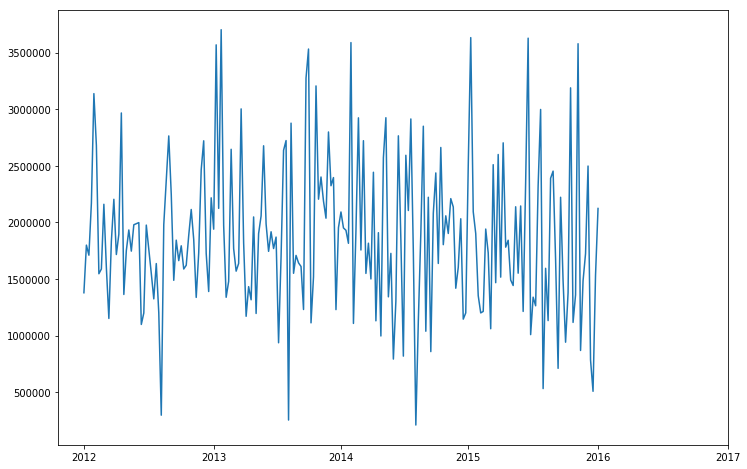

In [8]:
xticks = [0]

current_year = '2012'

for index, row in df.iterrows():
    if row['iso_year_week'][:4] != current_year:
        current_year = row['iso_year_week'][:4]
        xticks.append(index)

plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(train_input, train_output)
plt.xticks(xticks, ['2012', '2013', '2014', '2015', '2016', '2017'])
plt.show()